# Time Series Forecasting on NYC_Taxi

w MLFlow

- Objectives
  - Leverage ML FLow to build some time series models

- Simple Forecast of aggregate daily data to start
- Later will need to look at splitting out the datasets into different spots

In [14]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.98 ms (started: 2021-07-30 01:34:31 +00:00)


In [15]:
import os
from pyspark.sql import SparkSession
packages="""io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0"""
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell"

time: 2.95 ms (started: 2021-07-30 01:34:31 +00:00)


In [16]:
from pyspark.sql import functions as F
import pandas as pd

time: 6.6 ms (started: 2021-07-30 01:34:31 +00:00)


In [17]:
spark = SparkSession \
            .builder \
            .config("spark.executor.cores", 4) \
            .config("spark.executor.memory", "4g") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.master", "spark://spark-master:7077") \
            .config("spark.hadoop.fs.s3a.access.key", os.environ['MINIO_ACCESS_KEY']) \
            .config("spark.hadoop.fs.s3a.secret.key", os.environ['MINIO_SECRET_KEY']) \
            .config("spark.hadoop.fs.s3a.endpoint", "minio:9000") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.metastore.catalog.default", "hive") \
            .config("spark.sql.warehouse.dir", "s3a://storage/warehouse") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
            .config("spark.hive.metastore.uris", "thrift://192.168.64.4:9083") \
            .appName("Jupyter Time Series") \
            .enableHiveSupport() \
            .getOrCreate()

time: 8.74 ms (started: 2021-07-30 01:34:31 +00:00)


In [18]:
# tuning settings spark.sql.shuffle.partitions to match with core settings
# not tuned for file size yet

# set to cores to increase the efficiency
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism*4)

## faster pandas data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

time: 4.04 ms (started: 2021-07-30 01:34:31 +00:00)


In [19]:
from tseries.taxi_daily import TaxiDaily

time: 4.23 ms (started: 2021-07-30 01:34:31 +00:00)


In [20]:
taxi_daily = TaxiDaily(spark)
taxi_daily.load_data()

time: 107 ms (started: 2021-07-30 01:34:31 +00:00)


In [21]:
taxi_daily.train_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2013, 8, 1), max(ds)=datetime.date(2014, 6, 30))]

time: 12.5 s (started: 2021-07-30 01:34:31 +00:00)


In [22]:
taxi_daily.test_data.agg(F.min(F.col('ds')), F.max(F.col('ds'))).collect()

[Row(min(ds)=datetime.date(2014, 7, 1), max(ds)=datetime.date(2016, 6, 30))]

time: 12.9 s (started: 2021-07-30 01:34:44 +00:00)


In [23]:
train, test = taxi_daily.train_data.toPandas(), taxi_daily.test_data.toPandas()

time: 26.4 s (started: 2021-07-30 01:34:57 +00:00)


In [24]:
train_sktime = pd.Series(data=train['y'].values, index=pd.to_datetime(train['ds']))
test_sktime = pd.Series(data=test['y'].values, index=pd.to_datetime(test['ds']))

time: 1.81 ms (started: 2021-07-30 01:35:23 +00:00)


# Settings for MLflow

In [25]:
# credentials for storing our model artifacts
# mlflow needs these to be set whenever it is being called
os.environ['AWS_ACCESS_KEY_ID'] = os.environ.get('MINIO_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.environ.get('MINIO_SECRET_KEY')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'

time: 16.3 ms (started: 2021-07-30 01:35:23 +00:00)


## Forecasting the Dataframe

In [26]:
import prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import mlflow

time: 1.76 s (started: 2021-07-30 01:35:23 +00:00)


There was an error in the hostname resolution hence switch to ip

In [27]:
#mlflow.delete_experiment(1)

time: 134 µs (started: 2021-07-30 01:35:25 +00:00)


In [28]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 7.11 ms (started: 2021-07-30 01:35:25 +00:00)


In [29]:
### Quick test on creating experiments
from mlflow.exceptions import RestException

try:
    mlflow.create_experiment(
        name='taxi_daily_forecast'
    )
except RestException:
    print('already_created')

already_created
time: 541 ms (started: 2021-07-30 01:35:25 +00:00)


In [30]:
experiment = mlflow.get_experiment(15)
experiment.artifact_location

's3://mlflow/15'

time: 239 ms (started: 2021-07-30 01:35:25 +00:00)


In [31]:
# Build an evaluation function
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

time: 162 ms (started: 2021-07-30 01:35:26 +00:00)


In [32]:
# To save models to mlflow we need to write a python wrapper 
# to make sure that it performs as mlflow expects
import mlflow.pyfunc

class ProphetModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    def load_context(self, context):
        from prophet import Prophet
        return
    
    def predict(self, context, model_input):
        future = self.model.make_future_dataframe(periods=model_input['periods'][0])
        return self.model.predict(future)

time: 357 µs (started: 2021-07-30 01:35:26 +00:00)


44 seconds for training by default \
3.62 seconds with processes parallelisation \
13 seconds after we add the toPandas conversion here and run with parallelisation

In [33]:
%time

rolling_window = 0.1

conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'prophet=={0}'.format(prophet.__version__)
        ]
    }],
    "name": "prophetenv"
}

with mlflow.start_run(experiment_id=15):
    m = prophet.Prophet(daily_seasonality=True)
    m.fit(taxi_daily.train_data.toPandas())
    
    # cross validation is the thingy that is generating our different train sets
    # tqdm is glitchy with my setup so disabling for now
    df_cv = cross_validation(m, initial="28 days", period="7 days", horizon="14 days", 
                                 disable_tqdm=True, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=rolling_window)
    
    mlflow.log_param("rolling_window", rolling_window)
    mlflow.log_metric("rmse", df_p.loc[0, "rmse"])
    mlflow.log_metric("mae", df_p.loc[0, "mae"])
    mlflow.log_metric("mape", df_p.loc[0, "mape"])
    
    print("  CV: {}".format(df_cv.head()))
    print("  Perf: {}".format(df_p.head()))
    
    mlflow.pyfunc.log_model("model", conda_env=conda_env, python_model=ProphetModel(m))
    print(
            "Logged model with URI: runs:/{run_id}/model".format(
                run_id=mlflow.active_run().info.run_id
            )
        )

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 42 forecasts with cutoffs between 2013-09-02 00:00:00 and 2014-06-16 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcc69186a00>
INFO:botocore.credentials:Found credentials in environment variables.


  CV:           ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2013-09-03  501585.281837  429012.334753  578451.271268  423109 2013-09-02
1 2013-09-04  518817.592943  449223.701722  593426.747423  454753 2013-09-02
2 2013-09-05  504761.734693  430436.181074  577274.920129  468204 2013-09-02
3 2013-09-06  495324.421080  418819.479482  564843.236820  509666 2013-09-02
4 2013-09-07  474445.011476  403329.539406  548028.112755  512373 2013-09-02
  Perf:   horizon           mse          rmse           mae      mape     mdape  \
0  2 days  2.802909e+09  52942.502951  37278.418974  0.086742  0.049990   
1  3 days  3.124219e+09  55894.709955  37167.961699  0.085093  0.047995   
2  4 days  3.170948e+09  56311.167889  37426.567206  0.081971  0.043602   
3  5 days  2.723070e+09  52183.046660  38084.927978  0.074821  0.056177   
4  6 days  1.912054e+09  43727.040544  33739.912505  0.068865  0.045557   

      smape  coverage  
0  0.078420  0.874384  
1  0.077513  0.863711  
2

# Prophet Diagnostics

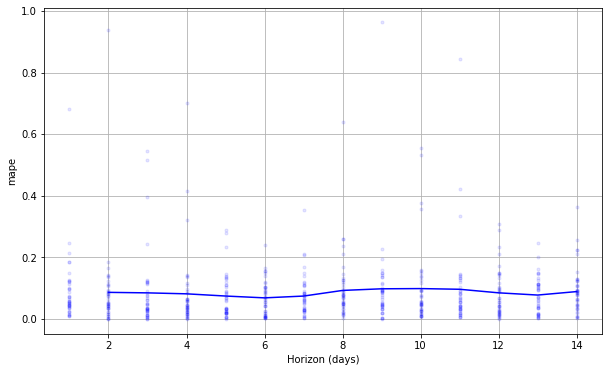

time: 111 ms (started: 2021-07-30 01:35:42 +00:00)


In [34]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

We aren't seeing many differences with longer horizons

In [35]:
future = m.make_future_dataframe(periods=len(taxi_daily.test_data.toPandas()))

time: 13.6 s (started: 2021-07-30 01:35:43 +00:00)


In [36]:
forecast = m.predict(future)

time: 2.61 s (started: 2021-07-30 01:35:56 +00:00)


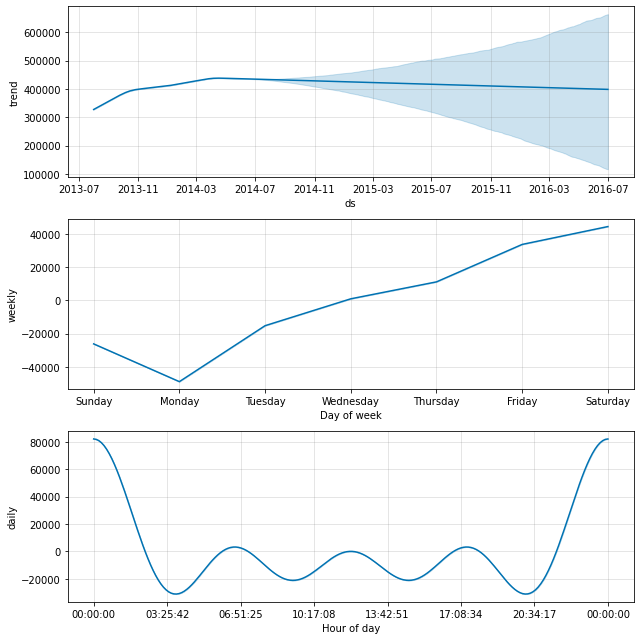

time: 293 ms (started: 2021-07-30 01:35:59 +00:00)


In [37]:
fig = m.plot_components(forecast)

# Testing out Uber Orbit

In [38]:
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

time: 290 ms (started: 2021-07-30 01:35:59 +00:00)


In [39]:
dlt = DLTFull(
    response_col='y', date_col='ds',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=7,
)

time: 337 µs (started: 2021-07-30 01:35:59 +00:00)


In [40]:
dlt.fit(df=taxi_daily.train_data.toPandas())

# outcomes data frame
predicted_df = dlt.predict(df=taxi_daily.test_data.toPandas())

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


time: 29.1 s (started: 2021-07-30 01:35:59 +00:00)


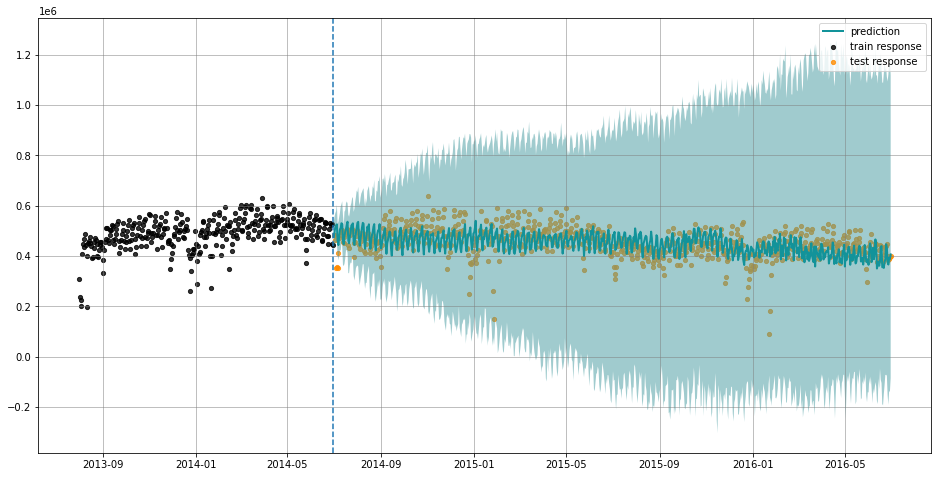

<AxesSubplot:>

time: 25.8 s (started: 2021-07-30 01:36:29 +00:00)


In [41]:
plot_predicted_data(
    training_actual_df=taxi_daily.train_data.toPandas(), predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=taxi_daily.test_data.toPandas()
)

# Testing sktime

In [42]:
from sktime.utils.plotting import plot_series
import numpy as np

time: 46.4 ms (started: 2021-07-30 01:36:54 +00:00)


In [43]:
print(len(test_sktime))
print(len(train_sktime))

731
334
time: 306 µs (started: 2021-07-30 01:36:54 +00:00)


In [44]:
print("min: {0}, max {1}".format(min(train_sktime.index), max(train_sktime.index)))
print("min: {0}, max {1}".format(min(test_sktime.index), max(test_sktime.index)))

min: 2013-08-01 00:00:00, max 2014-06-30 00:00:00
min: 2014-07-01 00:00:00, max 2016-06-30 00:00:00
time: 5.54 ms (started: 2021-07-30 01:36:54 +00:00)


In [45]:
train_tr = pd.date_range(min(train_sktime.index), max(train_sktime.index))
train_skt_df = pd.Series(train_sktime, index=train_tr)

test_tr = pd.date_range(min(test_sktime.index), max(test_sktime.index))
test_skt_df = pd.Series(test_sktime, index=test_tr)


time: 8.41 ms (started: 2021-07-30 01:36:54 +00:00)


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

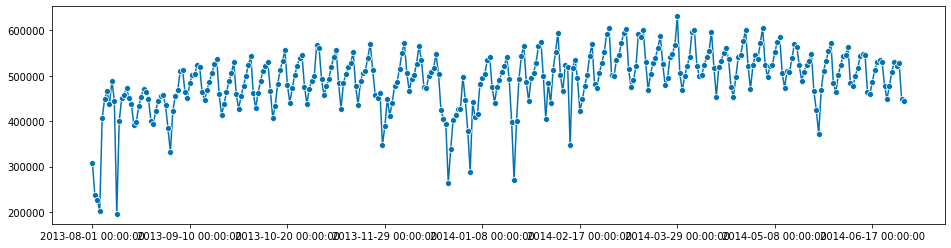

time: 132 ms (started: 2021-07-30 01:36:54 +00:00)


In [46]:
plot_series(train_sktime)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

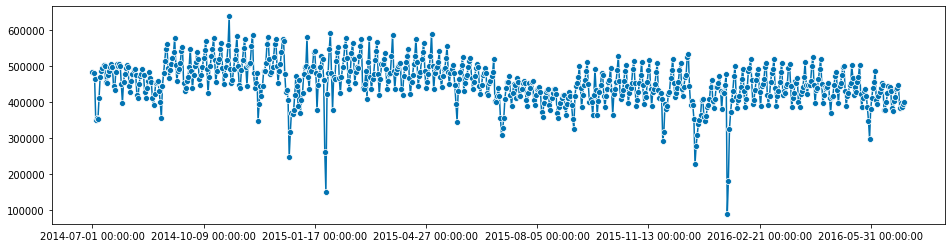

time: 148 ms (started: 2021-07-30 01:36:55 +00:00)


In [47]:
plot_series(test_sktime)

In [48]:
from sktime.forecasting.model_selection import temporal_train_test_split

time: 31.3 ms (started: 2021-07-30 01:36:55 +00:00)


In [49]:
# test pandas
#pd.PeriodIndex(pd.date_range("2020-01-01", periods=30, freq="D"))
from sktime.forecasting.base import ForecastingHorizon

#fh = ForecastingHorizon(test_sktime.index, is_relative=False)
fh_period = ForecastingHorizon(
    test_skt_df.index, is_relative=False
)

time: 1.06 ms (started: 2021-07-30 01:36:55 +00:00)


In [50]:
from sktime.forecasting.naive import NaiveForecaster

basic_forecaster =  NaiveForecaster(strategy="last")
forecaster = NaiveForecaster(strategy="last")

time: 7.42 ms (started: 2021-07-30 01:36:55 +00:00)


In [51]:
forecaster.fit(train_skt_df)

NaiveForecaster()

time: 8 ms (started: 2021-07-30 01:36:55 +00:00)


In [52]:
# stuck here for now
preds = forecaster.predict(fh_period)

time: 18.9 ms (started: 2021-07-30 01:36:55 +00:00)


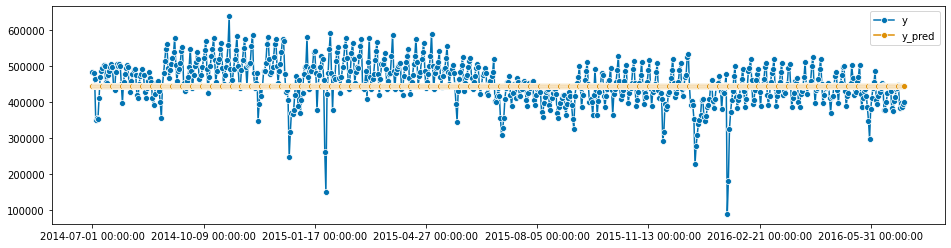

time: 221 ms (started: 2021-07-30 01:36:55 +00:00)


In [53]:
fig, ax = plot_series(test_skt_df, preds, labels=["y", "y_pred"])

In [54]:
from sktime.forecasting.theta import ThetaForecaster

time: 8.47 ms (started: 2021-07-30 01:36:55 +00:00)


In [55]:
# theta forecasting
th_forecaster = ThetaForecaster(sp=12)
th_forecaster.fit(train_skt_df)

alpha = 0.05
y_pred, y_pred_ints = th_forecaster.predict(fh_period, return_pred_int=True, alpha=alpha)

time: 15.9 ms (started: 2021-07-30 01:36:55 +00:00)


/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


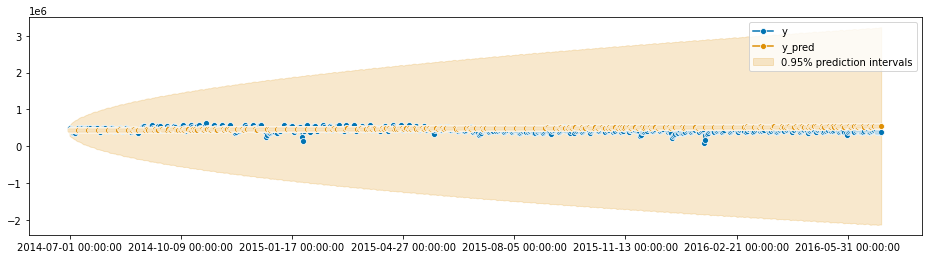

time: 232 ms (started: 2021-07-30 01:36:55 +00:00)


In [56]:
fig, ax = plot_series(test_skt_df, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

# GluonTS

In [138]:
from gluonts.dataset.common import ListDataset
import matplotlib.pyplot as plt

time: 455 µs (started: 2021-07-31 14:11:01 +00:00)


In [110]:
print(train_skt_df.values.shape)
print(test_skt_df.values.shape)

(334,)
(731,)
time: 604 µs (started: 2021-07-31 14:02:28 +00:00)


In [128]:
len(test_skt_df.values[0:14])

14

time: 1.45 ms (started: 2021-07-31 14:10:28 +00:00)


In [130]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': train_skt_df.values, 'start':train_skt_df.index[0] }],
    freq="1D"
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': test_skt_df.values[0:14], 'start': test_skt_df.index[0]}],
    freq="1D"
)

time: 943 µs (started: 2021-07-31 14:10:32 +00:00)


In [125]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

time: 441 µs (started: 2021-07-31 14:10:01 +00:00)


In [141]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=14,
    context_length=100,
    freq="D",
    trainer=Trainer(
        ctx="cpu",
        epochs=20,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

time: 768 µs (started: 2021-07-31 14:12:05 +00:00)


In [142]:
predictor = estimator.train(training_data=train_ds)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 321.86it/s, epoch=1/20, avg_epoch_loss=13.6]
INFO:gluonts.trainer:Epoch[0] Elapsed time 0.312 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=13.615164
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 329.73it/s, epoch=2/20, avg_epoch_loss=12.8]
INFO:gluonts.trainer:Epoch[1] Elapsed time 0.304 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=12.816647
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 334.05it/s, epoch=3/20, avg_epoch_loss=12.6]
INFO:gluonts.trainer:Epoch[2] Elapsed time 0.300 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=12.626152
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 338.22it/s, epoch=4/20, avg_epoch_loss=12.5]
INFO:gluonts.trainer:Epoch

time: 6.02 s (started: 2021-07-31 14:12:06 +00:00)


In [143]:
from gluonts.evaluation import make_evaluation_predictions

time: 400 µs (started: 2021-07-31 14:12:16 +00:00)


In [144]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

time: 493 µs (started: 2021-07-31 14:12:17 +00:00)


In [146]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

time: 7.52 ms (started: 2021-07-31 14:12:21 +00:00)


In [147]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

time: 569 µs (started: 2021-07-31 14:12:22 +00:00)


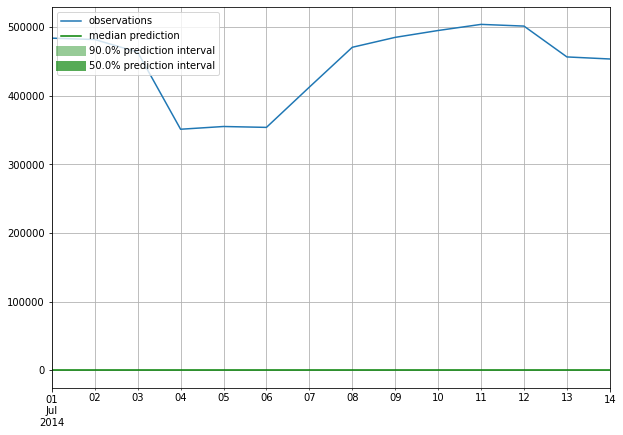

time: 155 ms (started: 2021-07-31 14:12:24 +00:00)


In [148]:
plot_prob_forecasts(ts_entry, forecast_entry)

# Statsmodels

In [117]:
import statsmodels.api as sm

time: 177 ms (started: 2021-07-26 15:37:06 +00:00)


In [122]:
mod = sm.tsa.SARIMAX(train['y'], order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  334
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -4064.632
Date:                Mon, 26 Jul 2021   AIC                           8135.264
Time:                        15:37:37   BIC                           8146.697
Sample:                             0   HQIC                          8139.822
                                - 334                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.545e+05   1.21e+04     12.788      0.000    1.31e+05    1.78e+05
ar.L1          0.6846      0.026     26.425      0.000       0.634       0.735
sigma2      2.125e+09      0.184   1.16e+10      0.0

## Stopping Spark Session

In [62]:
spark.stop()

time: 223 ms (started: 2021-07-29 14:03:05 +00:00)
